In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Datasets/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [4]:
images=[]

In [5]:
base_dir="/content/img_align_celeba/img_align_celeba"
files = os.listdir(base_dir)
for file in files:
  images.append(os.path.join(base_dir,file))


In [6]:
images=np.array(images)
images.shape
# (218, 178, 3)

(202599,)

(218, 178, 3)


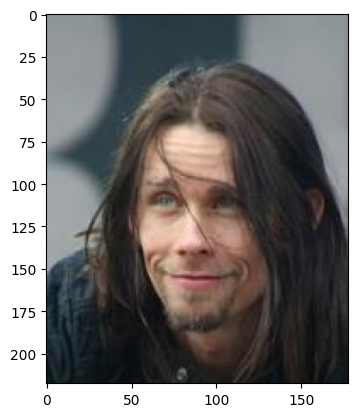

In [7]:
image = plt.imread(images[298])
print(image.shape)
plt.imshow(image)


In [8]:
from numpy import load
from numpy import zeros
from numpy import ones
from PIL import Image
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot


In [9]:
# define the discriminator model
def define_discriminator(color_shape,grey_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=grey_shape)
	# target image input
	in_target_image = Input(shape=color_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [10]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)

	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)

	# define model
	model = Model(in_image, out_image)
	return model

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, gray_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=gray_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [12]:
color_shape = (256, 256, 3)
gray_shape = (256, 256,1)
d_model = define_discriminator(color_shape,gray_shape)
d_model.summary()
#create the generator
g_model=define_generator(gray_shape)
# create the gan
g_model.summary()
gan_model = define_gan(g_model, d_model, gray_shape)
#summarize gan model
gan_model.summary()
# • plot gan model
# plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 4)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv2d_2 (Conv2D)              (None, 32, 32, 256)  524544      ['leaky_re_lu_1[0][0]']          
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 256)  1024       ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 32, 32, 256)  0           ['batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 512)  2097664     ['leaky_re_lu_2[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_3[0][0]']               
 rmalizati

In [64]:
# from PIL import Image
# import numpy as np

def generate_real_samples(image_paths, n_samples, patch_shape):
    desired_width = 256
    desired_height = 256

    color_images = []
    gray_image = []
    np.random.shuffle(image_paths)
    sample_paths = image_paths[:n_samples]

    for image_path in sample_paths:
        # Open the image using PIL
        image = Image.open(image_path)
        image = image.resize((desired_width, desired_height))
        image_gray = image.convert('L')  # Convert to grayscale
        image = np.array(image)
        image_gray = np.array(image_gray)

        image_gray =  np.expand_dims(image_gray, axis=-1)

        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        image = (image - 0.5) * 2  # Scale pixel values to [-1, 1]
        image_gray = image_gray.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        image_gray = (image_gray - 0.5) * 2  # Scale pixel values to [-1, 1]
        # Append the loaded image to the list

        color_images.append(image)
        gray_image.append(image_gray)

    y = ones((n_samples, patch_shape, patch_shape, 1))
    color_images = np.array(color_images)
    gray_image=np.array(gray_image)
    return [color_images,gray_image], y


(256, 256, 3)
(256, 256, 1)


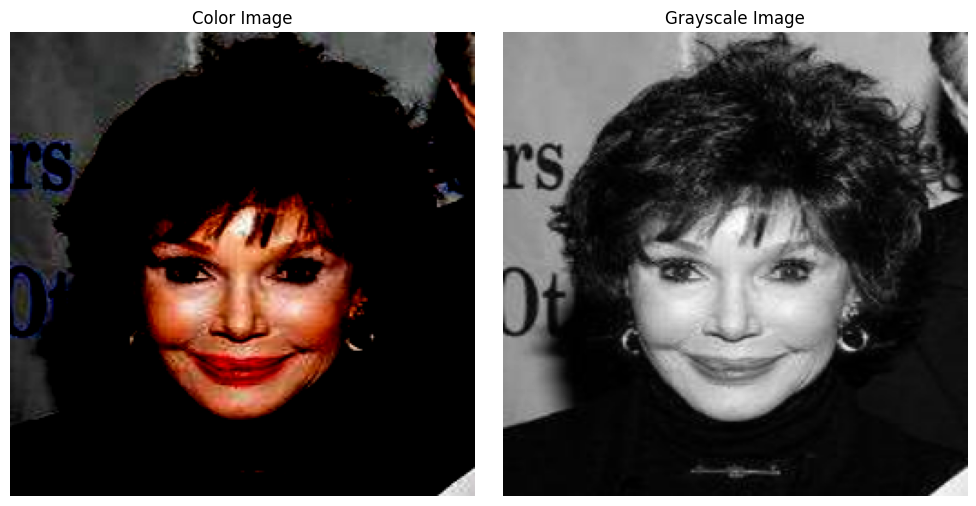

In [65]:
[color_images,gray_image], _= generate_real_samples(images,1,70)
plt.figure(figsize=(10, 5))
# Plot the color image
plt.subplot(1, 2, 1)
print(color_images[0].shape)
plt.imshow(color_images[0])
plt.title('Color Image')

plt.axis('off')  # Turn off axis labels and ticks

# Plot the grayscale image
plt.subplot(1, 2, 2)
print(gray_image[0].shape)
plt.imshow(gray_image[0], cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')  # Turn off axis labels and ticks

# Show the combined plot
plt.tight_layout()
plt.show()

In [66]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

1/1 [==============================] - 0s 30ms/step


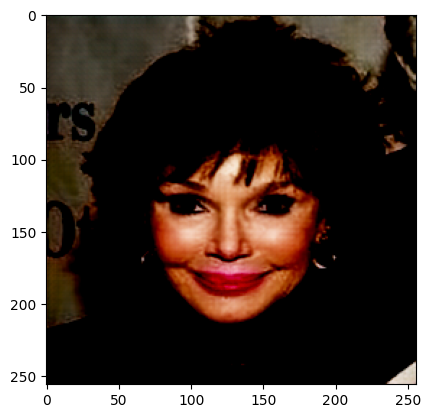

In [67]:
img= np.expand_dims(gray_image[0], axis=0)
x,y=generate_fake_samples(g_model,img,70)
plt.imshow(x[0])

In [17]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [color_image, gray_image], _ = generate_real_samples(dataset, n_samples, 1)
  # generate a batch of fake samples
  fake_color, _ = generate_fake_samples(g_model, gray_image, 1)
  # scale all pixels from [-1,1] to [0,1]
  color_image = (color_image + 1) / 2.0
  gray_image = (gray_image + 1) / 2.0
  fake_color = (fake_color + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(color_image[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(gray_image[i],cmap='gray')
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(fake_color[i])
  # save plot to file
  filename1 = f"plot_{step+1}.png"
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = f"model_{step+1}.h5"
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [18]:
summarize_performance(1,g_model,images)

1/1 [==============================] - 1s 1s/step


>Saved: plot_2.png and model_2.h5


In [19]:

# train the generator and discriminator
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  bat_per_epo=int(10000)
  n_patch = d_model.output_shape[1]
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set
    for j in range(bat_per_epo):
    #get randomly selected 'real' samples
      [color_image, gray_image], y_real = generate_real_samples(dataset, n_batch, n_patch)
      # generate a batch of fake samples
      color_fake, y_fake = generate_fake_samples(g_model, gray_image, n_patch)
      # update discriminator for real samples
      d_loss1 = d_model.train_on_batch([gray_image, color_image], y_real)
      # update discriminator for generated samples
      d_loss2 = d_model.train_on_batch([gray_image, color_fake], y_fake)
      # update the generator
      g_loss, _, _ = gan_model.train_on_batch(gray_image, [y_real, color_image])
      # ersummarize loss on this batch
      print(f">batch->{j+1}, d1[{d_loss1}], d2[{d_loss2}], g[{g_loss}]")
      #evaluate the model performance, sometimes
    if (i+1)%5 == 0:
      summarize_performance(i, g_model,dataset)

In [20]:
train(d_model, g_model, gan_model, images)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
>batch->7666, d1[0.15383511781692505], d2[0.10669884830713272], g[6.02423095703125]
1/1 [==============================] - 0s 20ms/step
>batch->7667, d1[0.09603168070316315], d2[0.10064677894115448], g[10.236237525939941]
1/1 [==============================] - 0s 24ms/step
>batch->7668, d1[0.06433874368667603], d2[0.10355257987976074], g[4.677584648132324]
1/1 [==============================] - 0s 25ms/step
>batch->7669, d1[0.05892729014158249], d2[0.09702055901288986], g[6.195764064788818]
1/1 [==============================] - 0s 34ms/step
>batch->7670, d1[0.053393565118312836], d2[0.1095907986164093], g[15.799269676208496]
1/1 [==============================] - 0s 34ms/step
>batch->7671, d1[0.05095874145627022], d2[0.09407061338424683], g[8.031905174255371]
1/1 [==============================] - 0s 32ms/step
>batch->7672, d1[0.05463080108165741], d2[0.09975818544626236], g[9.296468

KeyboardInterrupt: ignored

(256, 256, 1)
(1, 256, 256, 1)
1/1 [==============================] - 0s 43ms/step


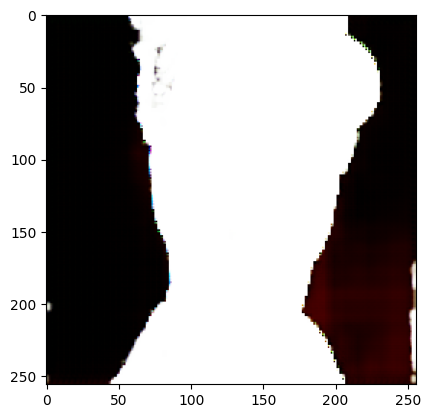

In [50]:
desired_width = 256
desired_height = 256
image_path="/content/text_image.jpg"
image = Image.open(image_path)
image = image.resize((desired_width, desired_height))
image_gray = image.convert('L')
image_gray = np.array(image_gray)
image_gray =  np.expand_dims(image_gray, axis=-1)
print(image_gray.shape)

image_gray =  np.expand_dims(image_gray, axis=0)
print(image_gray.shape)
fake_color, _ = generate_fake_samples(g_model, image_gray, 1)

plt.imshow(fake_color[0],cmap='gray')

In [31]:
filename2 = f"g__model_{4}.h5"
g_model.save(filename2)
filename3 = f"d_model_{4}.h5"
d_model.save(filename3)
filename4 = f"gan_model_{4}.h5"
gan_model.save(filename4)

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, n_samples=1):
  # select a sample of input images
  desired_width = 256
  desired_height = 256
  image_path="/content/text_image.jpg"
  image = Image.open(image_path)
  plt.imshow(image[0])
  image = image.resize((desired_width, desired_height))
  image_gray = image.convert('L')  # Convert to grayscale
  image_gray = np.array(image_gray)
  fimage_gray = image_gray.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
  image_gray = (image_gray - 0.5) * 2
  image_gray =  np.expand_dims(image_gray, axis=-1)
  print(image_gray.shape)
  # generate a batch of fake samples
  fake_color, _ = generate_fake_samples(g_model, image_gray, 1)
  # scale all pixels from [-1,1] to [0,1]

  plt.imshow(fake_color[0])

In [ ]:
summarize_performance(1,g_model)